In [1]:
import MySQLdb
import pandas
import matplotlib.pyplot as plt
import math
import csv
%matplotlib inline  

#Returns a dictionary of Fixations (startTime, endTime, duration, X, Y, sceName, depth, file, type) 
#and saccades (startTime, endTime, duration, startX, startY, endX, endY) 
def getSession(host,user,passwd,db, session_id, sensitivity):
        db = MySQLdb.connect(host=host,
                         user=user,
                         passwd=passwd,
                         db=db)
        #The maximum velocity allowed for a fixation recordings. (distance in pixels / time in ms)
        #Larger sensitivty, fewer sacades
        SENSITIVITY = sensitivity
        cursor = db.cursor()
        session_info = cursor.execute("SELECT * FROM session_info WHERE session_id='"+session_id+"'")
        df = pandas.read_sql("SELECT * FROM (SELECT * FROM gazes JOIN sces ON gazes.gaze_id=sces.sce_gaze_id) a WHERE a.gaze_session_id='" + session_id + "';", db)
        #df has all sces. dfu only has sce of depth 0.
        dfu = df.drop_duplicates(subset="gaze_id")
        #no style, is those views which are not associated with a sce. such as project explorer views.
        #self.dfNoStyle = pandas.read_sql("SELECT * FROM gazes WHERE path IS NULL", db)
        
        # I-VT. let's find some fixations!
        fixations = []
        saccades = []
        
        fix_list = []
        fixation = []
        prev_index = []
        
        
        for index, row in dfu.iterrows():
            if not(prev_index):
                prev_index = {'session_time' : row['session_time'], 
                              'x':row['x'], 'y':row['y'], 'sce_name':row['sce_name'],
                              'depth':row['depth'], 'gaze_name':row['gaze_name'], 'sce_type':row['sce_type'],
                              'gaze_session_id':row['gaze_session_id'],'line':row['line']}
                continue
            else:
                curr_index = {'session_time' : row['session_time'], 
                              'x':row['x'], 'y':row['y'], 'sce_name':row['sce_name'],
                              'depth':row['depth'], 'gaze_name':row['gaze_name'], 'sce_type':row['sce_type'],
                              'gaze_session_id':row['gaze_session_id'],'line':row['line']}
               
                if getVelocity(prev_index['x'],prev_index['y'],curr_index['x'],
                               curr_index['y'],prev_index['session_time'],curr_index['session_time']) < SENSITIVITY:
                    fixation.append(curr_index)
                else: 
                    #Checking we're not mid saccades (Fixaions have to be atleast 100ms)
                    if not fixation:
                        continue
                    
                    if (fixation[len(fixation)-1]['session_time']/1e6 - fixation[0]['session_time']/1e6 < 100):
                        fixation = []
                        continue

                    fix_list.append(fixation)
                    fixation = []
            prev_index = curr_index

            #fix_list is now a list, of lists of lists.
            #each list of lists, is a group of fixations. We then combine these to one fixation, so we eventually
            #can have only a list of fixations (list*list)
            
        for fix in fix_list:
            #Getting the x and y values, for centroid
            x_list = []
            y_list = []
            sce_list = []
            sce_type_list = []
            line_list = []
            id_list = []
            for i in fix:
                x_list.append(i['x'])
                y_list.append(i['y'])
                sce_list.append(i['sce_name'])
                sce_type_list.append(i['sce_type'])
                line_list.append(i['line'])
                id_list.append(i['gaze_session_id'])

            
            centroid_x = sum(x_list)/len(x_list)
            centroid_y = sum(y_list)/len(y_list)

            #startTime, endTime and duration in miliseconds.
            startTime = fix[0]['session_time']/1e9
            endTime = fix[len(fix)-1]['session_time']/1e9
            duration = endTime - startTime
            
            depth = 0 #Not supported, but some day, maybe?
            
            fileName = fix[0]['gaze_name']
            #Sce name, if two source code entities are very close, we pick the one with the most gazes.
            sce_name =  max(set(sce_list), key=sce_list.count)
            sce_type =  max(set(sce_type_list), key=sce_type_list.count)
            line =  max(set(line_list), key=line_list.count)
            gaze_session_id =  max(set(id_list), key=id_list.count)


            #Returns a dictionary of Fixations (startTime, endTime, duration, X, Y, sceName, depth, file) 
            fixations.append({'start_time':startTime,
                              'end_time':endTime, 'duration':duration, 
                              'x':centroid_x, 'y':centroid_y, 
                              'sce_name':sce_name, 'depth':depth, 
                              'file_name':fileName, 
                              'sce_type':sce_type, 'line':line,
                              'gaze_session_id':gaze_session_id})
        return [fixations, dfu]#, saccades
        
def getVelocity(x1,y1,x2,y2,t1,t2):
    #Finding distance between the points
    a = abs(x1-x2)
    b = abs(y1-y2)
    dist = math.sqrt((a**2)+(b**2))
    
    #Velocity, as distance/time
    time = (t2/1e6-t1/1e6)
    velocity = dist/time
    #print velocity, x1,x2,y1,y2
    return velocity

In [2]:
def scatterPlot(fixations):
    x_list = []
    y_list = []
    s_list = []
    
    #im = plt.imread("Udklip.PNG")
    #implot = plt.imshow(im)
    #plt.figure(figsize=(7,7)) # This increases resolution

    
    for point in fixations:
        x_list.append(point['x'])
        y_list.append(point['y'])
        s_list.append(point['end_time']*10)
    plt.gca().invert_yaxis()
    plt.scatter(x_list,y_list, s=s_list)
    i = 0
    for x, y in zip(x_list, y_list):
        plt.text(x, y, str(i), color="red", fontsize=12)
        i += 1
    #plt.savefig("test.pdf", format='pdf')

    plt.show()
    
    
    

In [3]:
#Comparison of gaze points and fixations
#iTrace2 = getSession("localhost","root","1234","iTrace",'20171023T150625-0853+0200',0.1)
#iTrace = getSession("localhost","root","1234","iTrace",'20171107T091604-0704+0100',0.1)


#iTrace = getSession("localhost","root","1234","iTrace",'20171113T201759-0381+0100',0.35) #Kasper
#iTrace1 = getSession("localhost","root","1234","iTrace",'20171114T091051-0592+0100',0.35) #ERIK
#iTrace2 = getSession("localhost","root","1234","iTrace",'20171114T091642-0771+0100',0.35) #Martin

iTrace1 = getSession("localhost","root","1234","iTrace",'20171201T092946-0684+0100',0.35) #ERIK
iTrace2 = getSession("localhost","root","1234","iTrace",'20171201T101056-0578+0100',0.35) #Martin
iTrace3 = getSession("localhost","root","1234","iTrace",'20171205T100741-0299+0100',0.35) #Peter
iTrace4 = getSession("localhost","root","1234","iTrace",'20171205T102737-0035+0100',0.35) #Fillip


#20171201T101056-0578+0100 #SORT2
#20171201T092946-0684+0100 #SORT1

#20171114T140552-0265+0100

#20171113T201759-0381+0100

#scatterPlot(iTrace1[0])


#Scatterplot of raw gazes. for comparison
#x = []
#y = []
#for index, row in iTrace1[1].iterrows():
#    x.append(row['x'])
#    y.append(row['y'])
#plt.gca().invert_yaxis()
#plt.scatter(x,y)
#plt.show()


In [4]:
#Fixations (startTime, endTime, duration, X, Y, sce_name, depth, file, sce_type)
def variable_duration_bar(fixations):
    x = []
    y = []
    x_ticks = []
    for i in fixations:
        x_ticks.append(i['sce_name'])
    
    x_ticks = list(set(x_ticks))
    durr = 0
    for name in x_ticks:
        for i in fixations:
            if i['sce_name'] == name:
                durr += i['duration']
        y.append(durr)
        durr = 0
    x = [i for i in range(len(x_ticks))]
    plt.xticks(x,x_ticks,rotation=80)
    plt.bar(x,y)
    plt.show()
    
def type_duration_bar(fixations):
    x = []
    y = []
    x_ticks = []
    for i in fixations:
        x_ticks.append(i['sce_type'])
    
    x_ticks = list(set(x_ticks))
    durr = 0
    for ftype in x_ticks:
        for i in fixations:
            if i['sce_type'] == ftype:
                durr += i['duration']
        y.append(durr)
        durr = 0
    x = [i for i in range(len(x_ticks))]
    plt.xticks(x,x_ticks,rotation=80)
    plt.bar(x,y)
    plt.show()

def variable_fixation_count_bar(fixations):
    x = []
    y = []
    x_ticks = []
    for i in fixations:
        x_ticks.append(i['sce_name'])
    
    x_ticks = list(set(x_ticks))
    count = 0
    for name in x_ticks:
        for i in fixations:
            if i['sce_name'] == name:
                count += 1
        y.append(count)
        count = 0
    x = [i for i in range(len(x_ticks))]
    plt.xticks(x,x_ticks,rotation=80)
    plt.bar(x,y)
    plt.show()
    
def type_fixation_count_bar(fixations):
    x = []
    y = []
    x_ticks = []
    for i in fixations:
        x_ticks.append(i['sce_name'])
    
    x_ticks = list(set(x_ticks))
    count = 0
    for ftype in x_ticks:
        for i in fixations:
            if i['sce_name'] == ftype:
                count += 1
        y.append(count)
        count = 0
    x = [i for i in range(len(x_ticks))]
    plt.xticks(x,x_ticks,rotation=80)
    plt.bar(x,y)
    plt.show()


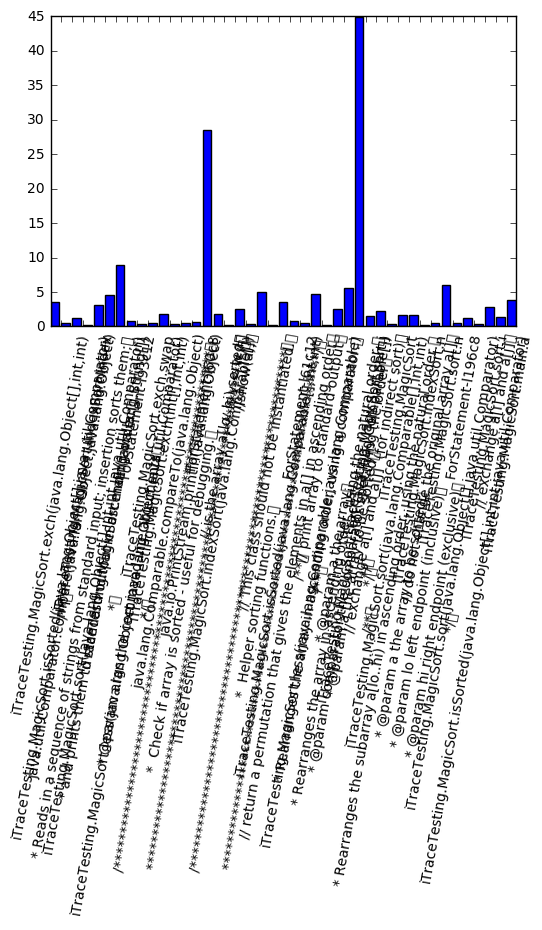

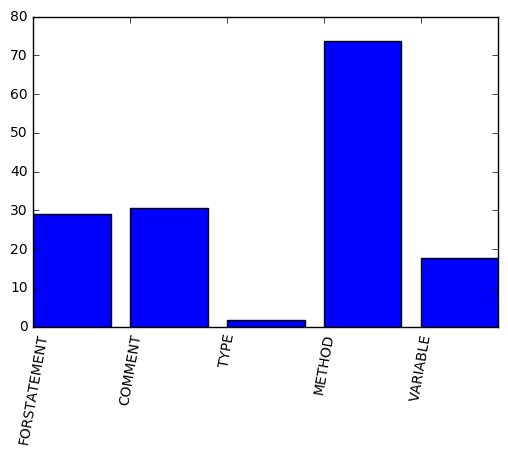

In [5]:
variable_duration_bar(iTrace1[0])
type_duration_bar(iTrace1[0])


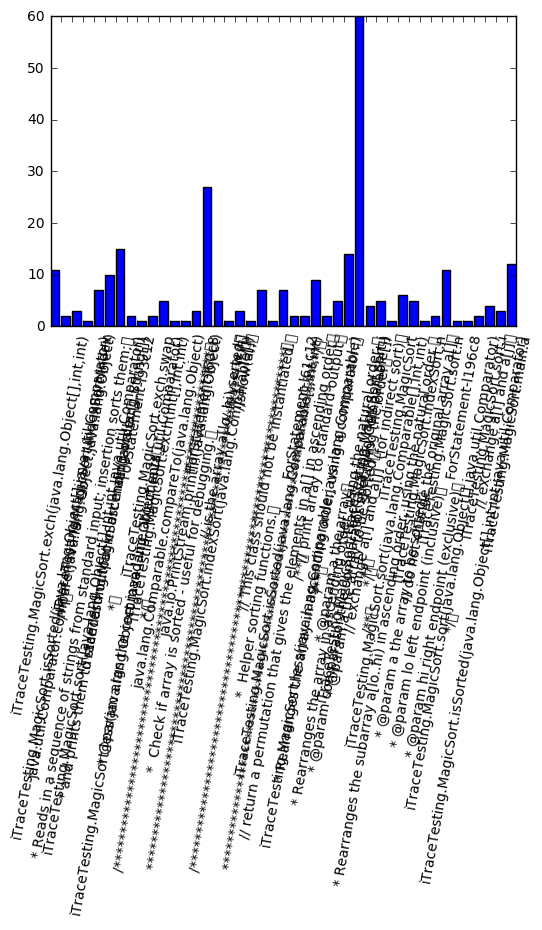

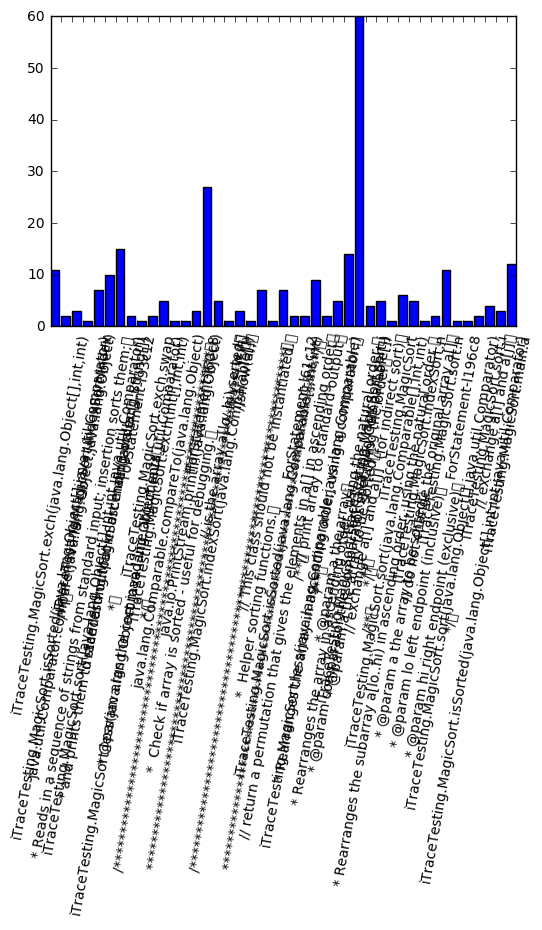

In [6]:
variable_fixation_count_bar(iTrace1[0])
type_fixation_count_bar(iTrace1[0])


In [7]:
def process_mining_data(fixations_list, csv_name, aoi, user_def='No'):
    #Make buckets, and define name of AoIs
    if(aoi == 'lines'):
        area = 'line'
        
    if (aoi == 'sce_grouped'):
        area = 'sce_type'
    if (aoi == 'sce'):
        area = 'sce_name'
        
    if (aoi == 'user_defined'):
        aoi_defs = []
        with open(user_def, 'rb') as csvfile:
            csv_reader = csv.reader(csvfile)
            for line in csv_reader:
                start = int(line[1])
                end = int(line[2])
                aoi_defs.append([line[0],[i for i in range(start,end+1)]])
            
    
    with open(csv_name, 'w') as csvfile:
        #initialising csv file
        csv_writer = csv.writer(csvfile, delimiter=',')
        csv_writer.writerow(["subject", "area of interest", "start", "end"])

        for fixations in fixations_list:
            #go through fixations and see if it matches a bucket. "empty" buckets whenever you find something from a new bucket.
            subject = ''
            name_of_aoi = ''
            start = 0
            end = 0
            aoi_list = []
            area_of_interest = []
            prev_fix = {}
            prev_group = ""
            fix_group = ""
            inAoI = False
            for fix in fixations:
                if(aoi == 'user_defined'):
                    for aoi_index in aoi_defs:
                        if (fix['line'] in aoi_index[1]):
                            inAoI = True
                    if (inAoI == False):
                        if not(area_of_interest == []): 
                            aoi_list.append(area_of_interest)
                            area_of_interest = []
                            prev_fix = {}
                            prev_group = ""
                        continue
                        
                
                if prev_fix == {}:
                    prev_fix = fix
                    if(aoi == 'user_defined'):
                        for aoi_index in aoi_defs:
                            if (prev_fix['line'] in aoi_index[1]):
                                prev_group = aoi_index[0]
                    continue
                    
                area_of_interest.append(prev_fix)
                
                if(aoi == 'user_defined'):
                    #if we don't set previous group (doesn't belong in any AoI), we dont append it.
                    #finding group for each fix
                    for aoi_index in aoi_defs:
                        if (fix['line'] in aoi_index[1]):
                            fix_group = aoi_index[0]
                    if (prev_group == fix_group and not (prev_fix['end_time']+1 < fix['start_time'])):
                        prev_fix = fix
                        prev_group = fix_group
                        
                    else:
                        aoi_list.append(area_of_interest)
                        area_of_interest = []
                        prev_fix = fix
                        prev_group = fix_group
                                
                #Not user_defined
                else:
                    if (prev_fix[area] == fix[area]):
                        prev_fix = fix
                        
                    else:
                        aoi_list.append(area_of_interest)
                        area_of_interest = []
                        prev_fix = fix
                #special case for last
                if (fix == fixations[len(fixations)-1]):
                    area_of_interest.append(fix)
                    aoi_list.append(area_of_interest)
                    
            for l in aoi_list:
                name_of_aoi = ""
                subject = l[0]['gaze_session_id']
                start = l[0]['start_time']
                end = l[len(l)-1]['end_time']
                print aoi
                if (aoi == 'user_defined'):
                    for aoi_index in aoi_defs:
                        if (l[0]['line'] in aoi_index[1]):
                            name_of_aoi = aoi_index[0]
                    #That special case, where the last fixation, which we had to add
                    if name_of_aoi == "":
                        continue
                else:
                    name_of_aoi = l[0][area]

                csv_writer.writerow([subject,name_of_aoi,start,end])
        
        
    
    #Make buckets, depending on lines, sces (type or name) or user defined lines

In [9]:
#process_mining_data([iTrace[0],iTrace1[0],iTrace2[0]],"test_user_def_1.csv",'user_defined',"test.csv")
#process_mining_data([iTrace[0],iTrace1[0],iTrace2[0]],"test_user_def_2.csv",'user_defined',"test2.csv")
#process_mining_data([iTrace[0]],"test_barbara.csv",'user_defined',"insertion.csv")

process_mining_data([iTrace1[0],iTrace2[0],iTrace3[0],iTrace4[0]],"test_sort.csv",'user_defined',"insertion.csv")

#process_mining_data(iTrace[0],"test_sce_group.csv",'sce_grouped')
#process_mining_data(iTrace[0],"test_sce.csv",'sce')


user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined
user_defined